In [44]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from  torchvision import datasets , transforms

In [45]:
transform_train = transforms.Compose([
    transforms.Resize(32,32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0 ,shear=10 , scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.Resize(32,32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


training_dataset = datasets.CIFAR10(root='./data',
                                    train=True,
                                    download=True,
                                    transform=transform_train)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset,
                                              batch_size=32,
                                              shuffle=True)

validation_dataset = datasets.CIFAR10(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                batch_size=32,
                                                shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [46]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    image = image.clip(0,1)
    return image

In [47]:
classes=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

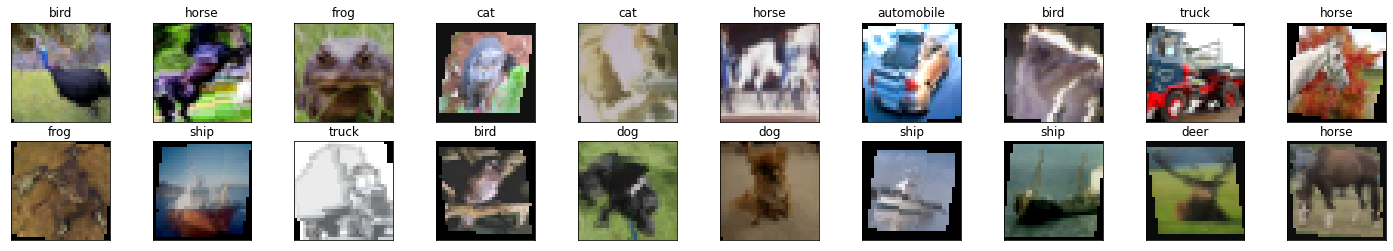

In [48]:
dataiter = iter(training_loader)
images , labels = dataiter.next()
imgage = images.to('cpu')
labels = labels.to('cpu')
fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
    ax = fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[i]))
    ax.set_title(classes[labels[i].item()])

In [49]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=16,
                               kernel_size=3,
                               stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               kernel_size=3,
                               stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,padding=1)
        self.fc1 = nn.Linear(4 * 4 * 64, 500)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        
        
        x = x.view(-1, 4 * 4 * 64)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [50]:
torch.manual_seed(2)
model = LeNet().to('cpu')
print(model)

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [52]:
epochs = 20
running_loss_history = []
running_correct_history = []

val_running_loss_history = []
val_running_correct_history = []
for i in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to('cpu')
        labels = labels.to('cpu')
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        running_loss += loss.item()
    else:
        with torch.no_grad():
            for val_inputs , val_labels in validation_loader:
                val_inputs = val_inputs.to('cpu')
                val_labels = val_labels.to('cpu')
#                 val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                val_running_loss += val_loss.item()
            
        epoch_loss = running_loss / len(training_loader)
        epoch_accuracy = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_accuracy)
        print('Training Loss: {:.4f} {:.4f}'.format(epoch_loss,
                                                    epoch_accuracy.item()))
        
        val_epoch_loss = running_loss / len(validation_loader)
        val_epoch_accuracy = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_correct_history.append(val_epoch_accuracy)
        print('Validation Loss: {:.4f} {:.4f}'.format(val_epoch_loss,
                                                    val_epoch_accuracy.item()))

Training Loss: 1.6215 12.9469
Validation Loss: 8.0970 16.7380
Training Loss: 1.3107 16.9495
Validation Loss: 6.5452 18.7125
Training Loss: 1.1795 18.5867
Validation Loss: 5.8899 20.2524
Training Loss: 1.1027 19.4511
Validation Loss: 5.5064 20.9904
Training Loss: 1.0452 20.2802
Validation Loss: 5.2194 21.4345
Training Loss: 1.0048 20.7729
Validation Loss: 5.0176 21.9297
Training Loss: 0.9724 21.1145
Validation Loss: 4.8560 21.6805
Training Loss: 0.9534 21.3756
Validation Loss: 4.7607 22.5144
Training Loss: 0.9294 21.6379
Validation Loss: 4.6408 22.6837
Training Loss: 0.9070 21.8733
Validation Loss: 4.5294 22.4601
Training Loss: 0.8980 22.0301
Validation Loss: 4.4841 23.1406
Training Loss: 0.8910 22.1337
Validation Loss: 4.4491 23.1022
Training Loss: 0.8703 22.2879
Validation Loss: 4.3457 23.1981
Training Loss: 0.8585 22.3813
Validation Loss: 4.2872 22.4633
Training Loss: 0.8621 22.4402
Validation Loss: 4.3052 23.3514
Training Loss: 0.8472 22.5790
Validation Loss: 4.2306 23.2875
Training

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [ ]:
plt.plot(running_correct_history, label='training accuracy')
plt.plot(val_running_correct_history, label='validation accuracy')
plt.legend()